# Project - Realtime Object Detection

## Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

2025-06-11 15:45:09.145610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 15:45:09.274067: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 15:45:09.386410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749671109.485056    1008 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749671109.512574    1008 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749671109.731154    1008 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Importing data

In [26]:
#Defining labels per dataset

# VisDrone categories of interest (ignore 0=ignored regions, 11=others)
visdrone_labels = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor"
}

mot17_labels = {1: "people"}  # single-class

In [39]:
# --- Root directory for datasets ---
data_root = "../data"

# --- Training sequence definitions ---
train_folders = [
    {
        "dataset": "MOT17",
        "img_path": os.path.join(data_root, "MOT17/train/MOT17-04/img1"),
        "ann_path": os.path.join(data_root,"MOT17/train/MOT17-04/gt/gt.txt"),
        "type": "mot"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000366_00001_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000366_00001_v.txt"),
        "type": "visdrone"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000013_01073_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000013_01073_v.txt"),
        "type": "visdrone"
    }

    # Add more VisDrone sequences as needed
]


In [50]:
#Creating a unified load sequence with correct annotation parsing
def load_sequence(info):
    if info["type"] == "mot":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = mot17_labels
    elif info["type"] == "visdrone":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = visdrone_labels
    else:
        raise ValueError("Unsupported dataset type.")

    image_files = sorted([
        os.path.join(img_dir, f) for f in os.listdir(img_dir)
        if f.endswith('.jpg')
    ])

    annotations = {}

    with open(gt_path, 'r') as f:
        for line in f:
            fields = line.strip().split(',')
            if info["type"] == "mot":
                if len(fields) < 8:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    mark = int(fields[6])
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if mark != 1 or obj_class not in labels:
                    continue

            elif info["type"] == "visdrone":
                if len(fields) < 10:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    score = int(float(fields[6]))
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if obj_class not in labels or score != 1:
                    continue

            box = [x, y, x + w, y + h, obj_class]
            annotations.setdefault(frame_id, []).append(box)

    return image_files, annotations, labels

In [51]:
def show_frame_with_boxes(img_path, boxes, class_labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in boxes:
        x1, y1, x2, y2, cls = map(int, box)
        label = class_labels.get(cls, str(cls))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


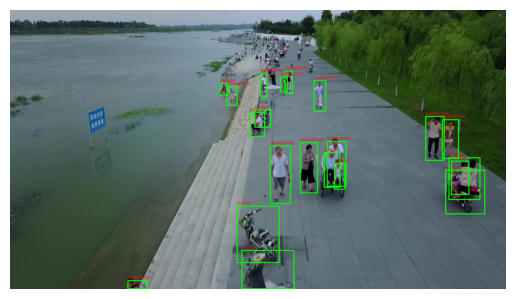

In [54]:
# Load a sequence (0 = MOT17, 1 = VisDrone)
sequence_info = train_folders[2]
img_files, annotations, labels = load_sequence(sequence_info)

# Show a frame
frame_id = 10
show_frame_with_boxes(img_files[frame_id], annotations.get(frame_id + 1, []), labels)


### Using Tensorflow for preprocessing the data

In [55]:
IMG_SIZE = (224, 224)

def preprocess_image_and_boxes(img_path, boxes, label_map):
    # Load and decode image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    orig_shape = tf.shape(img)[:2]  # (height, width)

    # Resize image
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # normalize

    # Convert boxes to tensor
    boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)

    # Rescale boxes according to new image size
    scale_y = tf.cast(IMG_SIZE[0], tf.float32) / tf.cast(orig_shape[0], tf.float32)
    scale_x = tf.cast(IMG_SIZE[1], tf.float32) / tf.cast(orig_shape[1], tf.float32)

    # Apply scaling to x1, y1, x2, y2
    boxes_scaled = boxes
    boxes_scaled = tf.stack([
        boxes[:, 0] * scale_x,
        boxes[:, 1] * scale_y,
        boxes[:, 2] * scale_x,
        boxes[:, 3] * scale_y,
        boxes[:, 4]
    ], axis=1)

    return img, boxes_scaled


In [56]:
all_img_paths = []
all_boxes = []
label_map = {}  # maps class_name -> ID

for seq_info in train_folders:
    img_files, annotations, labels = load_sequence(seq_info)

    # Merge label map
    for cls_id, cls_name in labels.items():
        label_map[cls_name] = cls_id

    for frame_id, frame_path in enumerate(img_files):
        frame_key = frame_id + 1  # because annotations are 1-based
        boxes = annotations.get(frame_key, [])
        if boxes:
            all_img_paths.append(frame_path)
            all_boxes.append(boxes)


In [57]:
# Wrap the data into a tf.data.Dataset
def generator():
    for img_path, box_list in zip(all_img_paths, all_boxes):
        yield img_path, box_list

output_types = (tf.string, tf.float32)
dataset = tf.data.Dataset.from_generator(generator, output_types=output_types)

# Map with preprocessing
dataset = dataset.map(lambda p, b: preprocess_image_and_boxes(p, b, label_map),
                      num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, prefetch
dataset = dataset.shuffle(512).padded_batch(8, 
            padded_shapes=([224, 224, 3], [None, 5])) \
            .prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Use output_signature instead


E0000 00:00:1749678671.788430    1008 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1749678671.794065    1008 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [62]:
for images, targets in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Bounding boxes shape:", targets.shape)  # (batch_size, num_boxes, 5)


Image batch shape: (8, 224, 224, 3)
Bounding boxes shape: (8, 47, 5)
